In [2]:
pip install -r requirements.txt

     ---------------------------------------- 0.0/60.9 kB ? eta -:--:--
     ------ --------------------------------- 10.2/60.9 kB ? eta -:--:--
     -------------------------------------- 60.9/60.9 kB 817.7 kB/s eta 0:00:00
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-25.2.10-py2.py3-none-any.whl.metadata (875 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached numpy-2.2.6-cp311-cp311-win_amd64.whl.metadata (60 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
     --------------


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

In [4]:
# Настройки отображения
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
sns.set_style('whitegrid')

# Пути к данным
BASE_DIR = Path.cwd()
GESTURE_DIR = BASE_DIR / 'Gesture'
TRAIN_DIR = GESTURE_DIR / 'train'
TEST_DIR = GESTURE_DIR / 'test'

print("Проверка наличия данных...")
print(f"Папка с данными: {GESTURE_DIR.exists()}")
print(f"Обучающая выборка: {TRAIN_DIR.exists()}")
print(f"Тестовая выборка: {TEST_DIR.exists()}")

# Параметры
IMG_SIZE = (64, 64)  # Размер изображения для обработки
BATCH_SIZE = 32
EPOCHS = 50
NUM_CLASSES = 20

Проверка наличия данных...
Папка с данными: True
Обучающая выборка: True
Тестовая выборка: True


In [5]:
# Анализ данных
def analyze_dataset():
    """Анализ структуры и содержания датасета"""
    print("=" * 50)
    print("АНАЛИЗ ДАННЫХ")
    print("=" * 50)
    
    # Подсчет количества изображений
    train_counts = {}
    test_counts = {}
    
    for gesture_id in range(NUM_CLASSES):
        train_path = TRAIN_DIR / str(gesture_id)
        test_path = TEST_DIR / str(gesture_id)
        
        train_counts[gesture_id] = len(list(train_path.glob('*.jpg')))
        test_counts[gesture_id] = len(list(test_path.glob('*.jpg')))
    
    # Создание DataFrame для анализа
    df_analysis = pd.DataFrame({
        'Класс': list(train_counts.keys()),
        'Обучающие изображения': list(train_counts.values()),
        'Тестовые изображения': list(test_counts.values())
    })
    
    print("Количество изображений по классам:")
    print(df_analysis)
    
    # Визуализация распределения классов
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    ax1.bar(df_analysis['Класс'], df_analysis['Обучающие изображения'])
    ax1.set_title('Распределение обучающих изображений по классам')
    ax1.set_xlabel('Класс жеста')
    ax1.set_ylabel('Количество изображений')
    
    ax2.bar(df_analysis['Класс'], df_analysis['Тестовые изображения'])
    ax2.set_title('Распределение тестовых изображений по классам')
    ax2.set_xlabel('Класс жеста')
    ax2.set_ylabel('Количество изображений')
    
    plt.tight_layout()
    plt.savefig('class_distribution.png')
    plt.show()
    
    
    return df_analysis

In [6]:
def show_sample_images():
    """Показать примеры изображений из каждого класса"""
    fig, axes = plt.subplots(4, 5, figsize=(15, 12))
    axes = axes.ravel()
    
    for i in range(NUM_CLASSES):
        class_dir = TRAIN_DIR / str(i)
        img_path = list(class_dir.glob('*.jpg'))[0]
        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        axes[i].imshow(img)
        axes[i].set_title(f'Класс {i}')
        axes[i].axis('off')
    
    plt.suptitle('Примеры изображений жестов по классам', fontsize=16)
    plt.tight_layout()
    plt.savefig('sample_images.png')
    plt.show()

АНАЛИЗ ДАННЫХ
Количество изображений по классам:
    Класс  Обучающие изображения  Тестовые изображения
0       0                    900                   300
1       1                    900                   300
2       2                    900                   300
3       3                    900                   300
4       4                    900                   300
5       5                    900                   300
6       6                    900                   300
7       7                    900                   300
8       8                    900                   300
9       9                    900                   300
10     10                    900                   300
11     11                    900                   300
12     12                    900                   300
13     13                    900                   300
14     14                    900                   300
15     15                    900                   300
16     16       

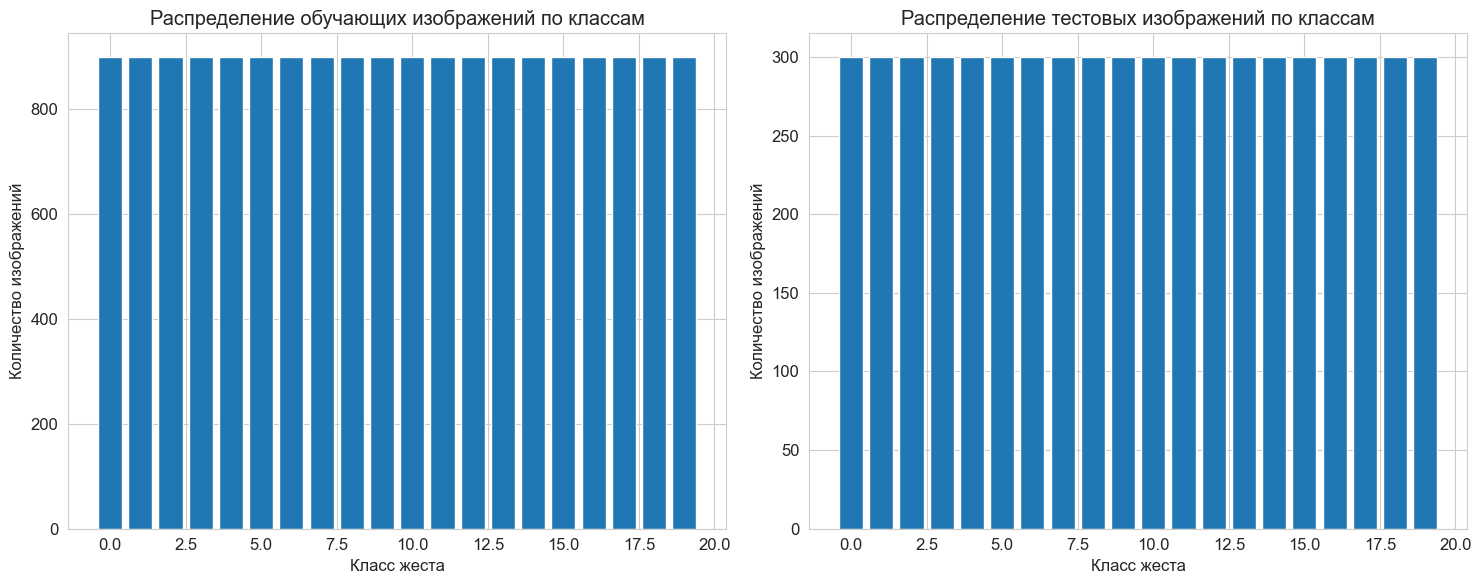

,Класс,Обучающие изображения,Тестовые изображения
0,0,900,300
1,1,900,300
2,2,900,300
3,3,900,300
4,4,900,300
5,5,900,300
6,6,900,300
7,7,900,300
8,8,900,300
9,9,900,300


In [7]:
analyze_dataset()

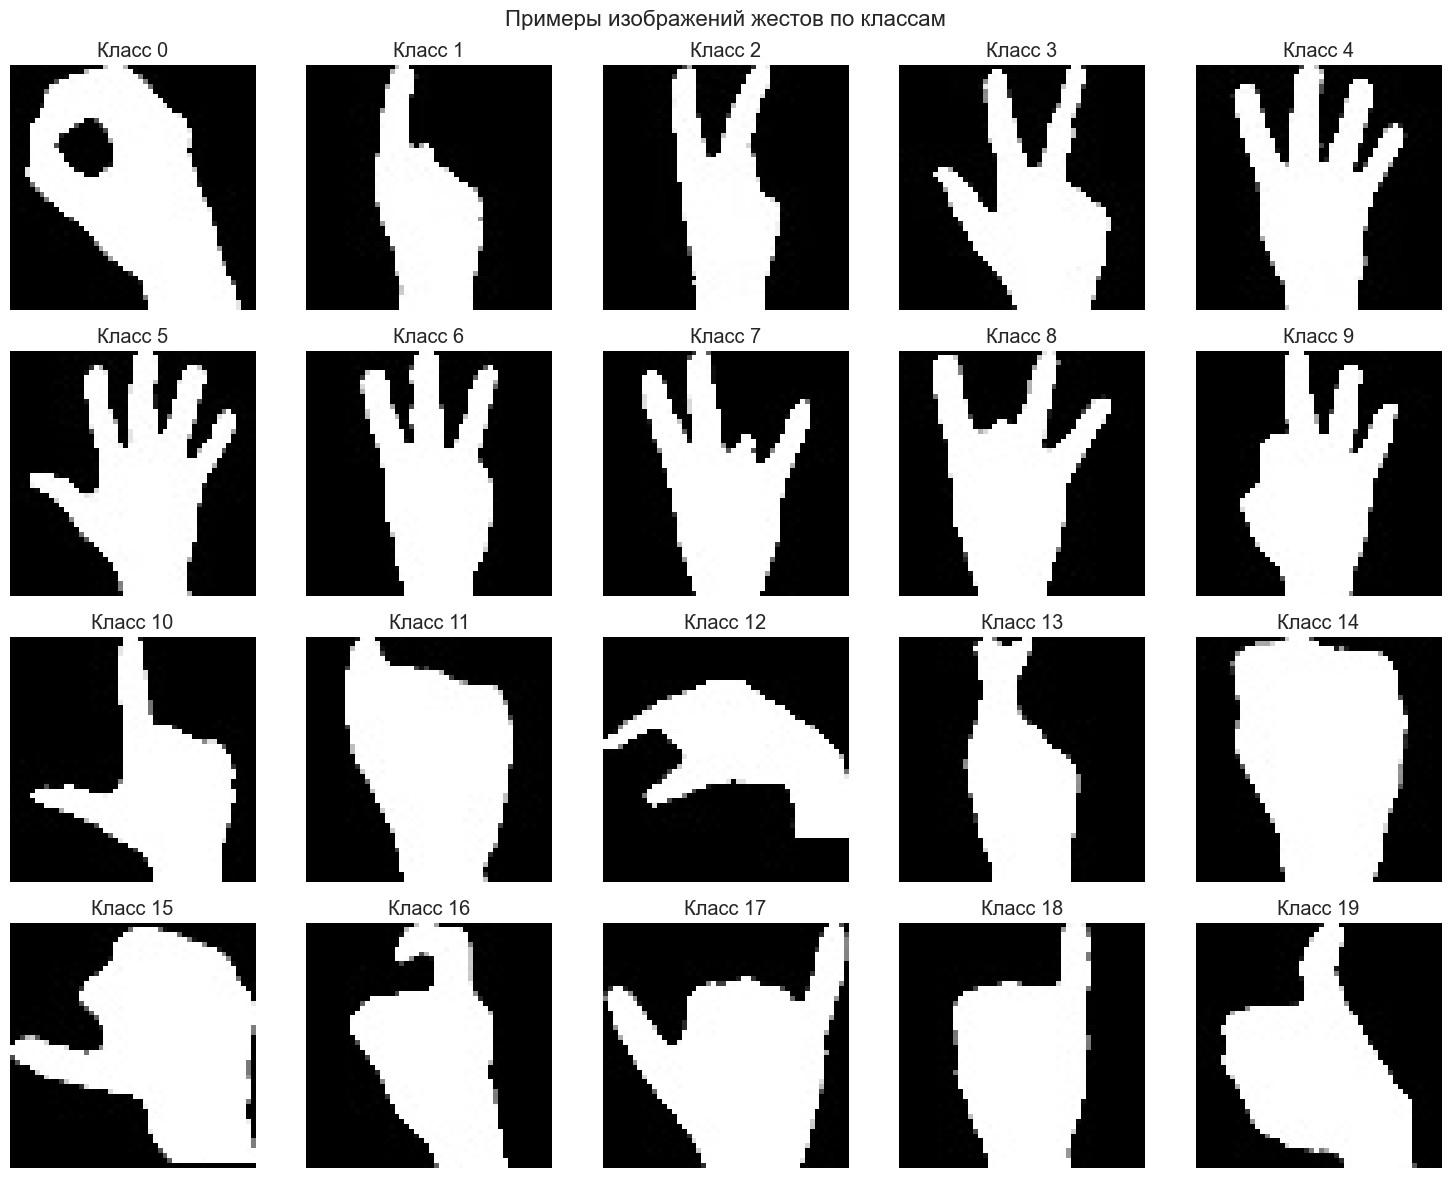

In [8]:
show_sample_images()